In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

#import json

In [2]:
# a small little ruse
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36'
}

In [3]:
def get_info(url):
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    # find the table from website
    table = soup.find('section', class_ = 'SnSstyle__GameCardsWrapper-sc-1m2zl7j-0 kvgDVy')

    info = table.findChildren()[0].text
    
    return info

In [4]:
url = 'https://www.mlb.com/schedule/2021-09-16'
get_info(url)

'ThursdaySep 16CINCIN@PITPITCIN 1, PIT 0OAKOAK@KCKCOAK 7, KC 2LAALAA@CWSCWSLAA 9, CWS 3SDSD@SFSFSD 7, SF 4NYYNYY@BALBALBAL 3, NYY 2CHCCHC@PHIPHIPHI 17, CHC 8DETDET@TBTBTB 5, DET 2HOUHOU@TEXTEXHOU 12, TEX 1COLCOL@ATLATLCancelledFridaySep 17COLCOL@WSHWSHCOL 9, WSH 8CLECLE@NYYNYYNYY 8, CLE 0MINMIN@TORTORMIN 7, TOR 3BALBAL@BOSBOSBOS 7, BAL 1LADLAD@CINCINCIN 3, LAD 1DETDET@TBTBTB 7, DET 4PHIPHI@NYMNYMPHI 4, NYM 3PITPIT@MIAMIAPIT 2, MIA 1CWSCWS@TEXTEXCWS 8, TEX 0AZAZ@HOUHOUHOU 4, AZ 3SEASEA@KCKCSEA 6, KC 2CHCCHC@MILMILMIL 8, CHC 5SDSD@STLSTLSTL 8, SD 2OAKOAK@LAALAAOAK 5, LAA 4ATLATL@SFSFSF 6, ATL 5SaturdaySep 18CLECLE@NYYNYYCLE 11, NYY 3BALBAL@BOSBOSBOS 9, BAL 3LADLAD@CINCINLAD 5, CIN 1MINMIN@TORTORTOR 6, MIN 2COLCOL@WSHWSHCOL 6, WSH 0DETDET@TBTBDET 4, TB 3PITPIT@MIAMIAPIT 6, MIA 3CWSCWS@TEXTEXTEX 2, CWS 1AZAZ@HOUHOUAZ 6, HOU 4SEASEA@KCKCKC 8, SEA 1SDSD@STLSTLSTL 3, SD 2PHIPHI@NYMNYMPHI 5, NYM 3CHCCHC@MILMILMIL 6, CHC 4ATLATL@SFSFSF 2, ATL 0OAKOAK@LAALAAOAK 3, LAA 1'

In [5]:
def get_date_range_info(start_date, end_date):
    
    dates = pd.date_range(start=start_date, 
                          end=end_date, 
                          freq='3D')
    dates_for_urls = []
    for date in dates: 
        dates_for_urls.append(str(date)[:10])
        
    urls_to_scrape = []
    for date in dates_for_urls:
        url = f'https://www.mlb.com/schedule/{date}'
        urls_to_scrape.append(url)
        
    infos = {}
    for url in urls_to_scrape:
        infos[url] = get_info(url)

    save_to_df = pd.DataFrame.from_dict(infos, orient='index', columns=['info_string'])
    
    return save_to_df

In [6]:
def to_a_df(string):
    
    day_of_week = []
    months = []
    dates = []
    away_teams = []
    home_teams = []
    winning_teams = []
    winning_scores = []
    losing_teams = []
    losing_scores = []
    
 
    DAY_COUNT = 0

    first_pass = True

    while DAY_COUNT < 3: 

        if first_pass: 
                
            split_first_space = string.split(' ',1)  

            # split_first_space[0] = 'WednesdayOct'
            day = split_first_space[0][:-3]     # 'Wednesday' 'Thursday' 'Friday'
            month = split_first_space[0][-3:]  # 'Oct' 'Oct' 'Oct'

            split_first = split_first_space[1].split(' ', 1)  

            # postponed games are always listed last (no played games will come after so skip
            # to new day and start loop over)
            if 'Postponed' in split_first[0]:
            
                # add to DAY_COUNT
                DAY_COUNT += 1

                postpone_split = split_first[0].split('Postponed')
                string = postpone_split[-1]+' '+split_first[1]         

            elif 'Cancelled' in split_first[0]:
                
                # add to DAY_COUNT
                DAY_COUNT += 1
                
                first_pass = True

                cancel_split = split_first[0].split('Cancelled')
               
                if len(split_first) > 1:
                    string = cancel_split[-1]+' '+split_first[1]
                    
            # if there is an '@' within first 10 characters then there is a game on this day
            elif '@' in split_first[0][:10]: 

                # split first element at the '@' symbol, the number is the DATE 
                split_at = split_first[0].split('@')

                day_of_week.append(day)
                months.append(month)
            
                date = ''.join(filter(str.isdigit, split_at[0]))  # '5' is the date because this is first pass
                dates.append(date) 

                almost_away = split_at[0].replace(date, '')
                mirror_point = int(len(almost_away)/2)
                away = almost_away[:mirror_point]
                away_teams.append(away)


                if (int(len(split_at[1])) == 9) or (int(len(split_at[1])) == 8):
                    home = split_at[1][:3]   # 'BAL'
                else:
                    home = split_at[1][:2]
                home_teams.append(home)

                if split_at[1] == home+home+home:
                    win = home
                elif split_at[1] == away+away+away:
                    win = away
                elif split_at[1] == home+home+away:
                    win = away
                else: #split_at[1] == away+away+home
                    win = home
                winning_teams.append(win)
                
                split_comma = split_first[1].split(', ', 1)  

                W_score = split_comma[0] # '5'
                winning_scores.append(W_score)

                split_space = split_comma[1].split(' ', 1)

                lose = split_space[0]  # 'TOR'
                losing_teams.append(lose)

                split_first = split_space[1].split(' ', 1) 

                first_pass = False

            else:
            # if there is NOT an '@' in first 10 characters of split_first[0] then there are NO GAMES on this day
            # there will be a message that says no games -or- says it is not a regular season game:

                # add to DAY_COUNT
                DAY_COUNT += 1
                
                no_game_sentence = 'There are no games scheduled for this date.'

                wild_card_sentence = 'Card'

                series = 'Series'


                 # How to start loop over
                if no_game_sentence in split_first_space[1][:50]:

                    resetting_string = split_first_space[1].split(no_game_sentence, 1)

                    string = resetting_string[1]

                else:

                    # look for next day of the week and start there
                    # NEED TO FIND NEXT DAY
                    for dow in ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']:

                        if dow in split_first_space[1]:

                            find_this_day_of_week = dow

                            break # out of day of the week for loop

                    start_day_of_week_substring = split_first_space[1].find(dow)

                    if start_day_of_week_substring != -1:
                        string = split_first_space[1][start_day_of_week_substring:]
                        
        else: # if first_pass = False

            L_score = ''.join(filter(str.isdigit, split_first[0]))  # '4' losing score for first day
            losing_scores.append(L_score) 

            # postponed games are always listed last (no played games will come after so skip
            # to new day and start loop over)
            if 'Postponed' in split_first[0]:
                
                # add to DAY_COUNT
                DAY_COUNT += 1
                
                first_pass = True

                postpone_split = split_first[0].split('Postponed')
               
                if len(split_first) > 1:
                    string = postpone_split[-1]+' '+split_first[1]
                    
            elif 'Cancelled' in split_first[0]:
                
                # add to DAY_COUNT
                DAY_COUNT += 1
                
                first_pass = True

                cancel_split = split_first[0].split('Cancelled')
               
                if len(split_first) > 1:
                    string = cancel_split[-1]+' '+split_first[1]
                    
                     
            # if there is an '@' within first 10 characters then there is a game on this day
            elif '@' in split_first[0][:10]: 

                # split first element at the '@' symbol, the number is the DATE 
                split_at = split_first[0].split('@')

                # new game starts here
                day_of_week.append(day)
                months.append(month) 
                dates.append(date)

                almost_away = split_at[0].replace(L_score, '')
                mirror_point = int(len(almost_away)/2)
                away = almost_away[:mirror_point]
                away_teams.append(away)

                
                if (int(len(split_at[1])) == 9) or (int(len(split_at[1])) == 8):
                    home = split_at[1][:3]   # 'BAL'
                else:
                    home = split_at[1][:2]
                home_teams.append(home)

                
                if split_at[1] == home+home+home:
                    win = home
                elif split_at[1] == away+away+away:
                    win = away
                elif split_at[1] == home+home+away:
                    win = away
                else: #split_at[1] == away+away+home
                    win = home
                winning_teams.append(win)

                split_comma = split_first[1].split(', ', 1)  

                W_score = split_comma[0] # '5'
                winning_scores.append(W_score)
               
                split_space = split_comma[1].split(' ', 1)

                lose = split_space[0]  # 'BAL'
                losing_teams.append(lose)
                
                split_first = split_space[1].split(' ', 1) 

            else:
                # if there is not an '@' within the first 10 characters of split_first[0]
                remove_num = split_first[0].replace(L_score, '') # example: 'ThursdayOct'
                DAY_COUNT += 1
                first_pass = True

                if len(split_first) > 1:
                    string = remove_num+' '+split_first[1]  # example: 'ThursdayOct 6There are...'

                    
                    
    to_df_dict = {'Day': day_of_week, 
                  'Month': months, 
                  'Date': dates, 
                  'Away': away_teams, 
                  'Home': home_teams, 
                  'Win': winning_teams, 
                  'W Score': winning_scores, 
                  'Lose': losing_teams, 
                  'L Score': losing_scores}

    return pd.DataFrame(data=to_df_dict)

In [7]:
def annual_games(string_df):
    three_day_dfs = []
    for index, row in string_df.iterrows():
        info = string_df['info_string'][index]
        three_day_dfs.append(to_a_df(info))

    games_by_day_for_the_year = pd.concat(three_day_dfs, ignore_index=True)
    
    return games_by_day_for_the_year

In [ ]:
def date_range_to_df(start_date, end_date):
    dates = pd.date_range(start=start_date, 
                          end=end_date, 
                          freq='3D')
    dates_for_urls = []
    for date in dates: 
        dates_for_urls.append(str(date)[:10])
        
    urls_to_scrape = []
    for date in dates_for_urls:
        url = f'https://www.mlb.com/schedule/{date}'
        urls_to_scrape.append(url)
        
    dfs = []
    for url in urls_to_scrape:
        dfs.append(to_a_df(url)) 
        
    games_by_day_for_the_year = pd.concat(dfs, ignore_index=True)
    
    return games_by_day_for_the_year
    

# Get all the games for 2017 Regular Season


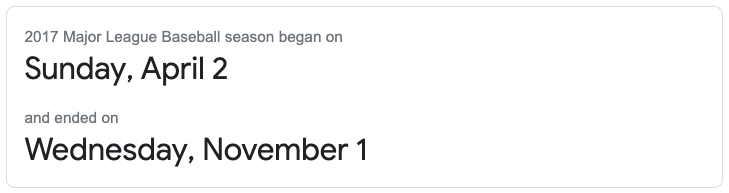

<center> *end dates are slightly different since I am only looking at Regular Season games.

In [8]:
# WARNING: this takes 5 - 10 mins
# only run this once, load df when rerunning notebook


#seventeen = get_date_range_info('2017-04-02', '2017-10-01')
#pd.to_pickle(seventeen, "../pickled_tables/info_strings_2017.pkl")

In [9]:
info_strings_2017 = pd.read_pickle("../pickled_tables/info_strings_2017.pkl")
info_strings_2017

,info_string
https://www.mlb.com/schedule/2017-04-02,"SundayApr 2NYYNYY@TBTBTB 7, NYY 3SFSF@AZAZAZ 6..."
https://www.mlb.com/schedule/2017-04-05,"WednesdayApr 5KCKC@MINMINMIN 9, KC 1TORTOR@BAL..."
https://www.mlb.com/schedule/2017-04-08,"SaturdayApr 8BOSBOS@DETDETDET 4, BOS 1MINMIN@C..."
https://www.mlb.com/schedule/2017-04-11,"TuesdayApr 11MINMIN@DETDETDET 2, MIN 1CWSCWS@C..."
https://www.mlb.com/schedule/2017-04-14,"FridayApr 14PITPIT@CHCCHCPIT 4, CHC 2PHIPHI@WS..."
...,...
https://www.mlb.com/schedule/2017-09-17,"SundaySep 17BALBAL@NYYNYYBAL 6, NYY 4KCKC@CLEC..."
https://www.mlb.com/schedule/2017-09-20,"WednesdaySep 20MINMIN@NYYNYYNYY 11, MIN 3OAKOA..."
https://www.mlb.com/schedule/2017-09-23,"SaturdaySep 23LAALAA@HOUHOUHOU 6, LAA 2CHCCHC@..."
https://www.mlb.com/schedule/2017-09-26,"TuesdaySep 26BALBAL@PITPITPIT 10, BAL 1WSHWSH@..."


In [10]:
games_by_day_2017 = annual_games(info_strings_2017)
pd.to_pickle(games_by_day_2017, "../pickled_tables/2017_df.pkl")

games_by_day_2017.tail()

,Day,Month,Date,Away,Home,Win,W Score,Lose,L Score
2425,Sunday,Oct,1,CWS,CLE,CLE,3,CWS,1
2426,Sunday,Oct,1,ATL,MIA,ATL,8,MIA,5
2427,Sunday,Oct,1,AZ,KC,AZ,14,KC,2
2428,Sunday,Oct,1,MIL,STL,MIL,6,STL,1
2429,Sunday,Oct,1,CIN,CHC,CIN,3,CHC,1


# Get games for 2018 Regular Season

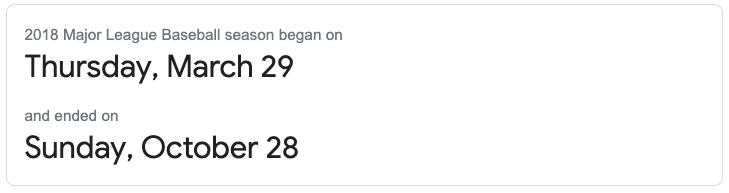

<center> *end dates are slightly different since I am only looking at Regular Season games.

In [11]:
# WARNING: this takes 5 - 10 mins
# only run this once, load df when rerunning notebook


#eighteen = get_date_range_info('2018-03-29', '2018-10-01')
#pd.to_pickle(eighteen, "../pickled_tables/info_strings_2018.pkl")

In [12]:
info_strings_2018 = pd.read_pickle("../pickled_tables/info_strings_2018.pkl")
info_strings_2018

,info_string
https://www.mlb.com/schedule/2018-03-29,"ThursdayMar 29CHCCHC@MIAMIACHC 8, MIA 4STLSTL@..."
https://www.mlb.com/schedule/2018-04-01,"SundayApr 1MINMIN@BALBALMIN 7, BAL 0NYYNYY@TOR..."
https://www.mlb.com/schedule/2018-04-04,"WednesdayApr 4WSHWSH@ATLATLATL 7, WSH 1TBTB@NY..."
https://www.mlb.com/schedule/2018-04-07,"SaturdayApr 7NYMNYM@WSHWSHNYM 3, WSH 2TBTB@BOS..."
https://www.mlb.com/schedule/2018-04-10,"TuesdayApr 10TBTB@CWSCWSTB 6, CWS 5PITPIT@CHCC..."
...,...
https://www.mlb.com/schedule/2018-09-19,"WednesdaySep 19STLSTL@ATLATLATL 7, STL 3MINMIN..."
https://www.mlb.com/schedule/2018-09-22,"SaturdaySep 22SFSF@STLSTLSTL 5, SF 4PHIPHI@ATL..."
https://www.mlb.com/schedule/2018-09-25,"TuesdaySep 25KCKC@CINCINKC 4, CIN 3MIAMIA@WSHW..."
https://www.mlb.com/schedule/2018-09-28,"FridaySep 28CWSCWS@MINMINMIN 2, CWS 1CWSCWS@MI..."


In [13]:
games_by_day_2018 = annual_games(info_strings_2018)
pd.to_pickle(games_by_day_2018, "../pickled_tables/2018_df.pkl")

games_by_day_2018.tail()

,Day,Month,Date,Away,Home,Win,W Score,Lose,L Score
2428,Sunday,Sep,30,DET,MIL,MIL,11,DET,0
2429,Sunday,Sep,30,CLE,KC,CLE,2,KC,1
2430,Sunday,Sep,30,STL,CHC,CHC,10,STL,5
2431,Monday,Oct,1,MIL,CHC,MIL,3,CHC,1
2432,Monday,Oct,1,COL,LAD,LAD,5,COL,2


# Get games for 2019 Regular Season

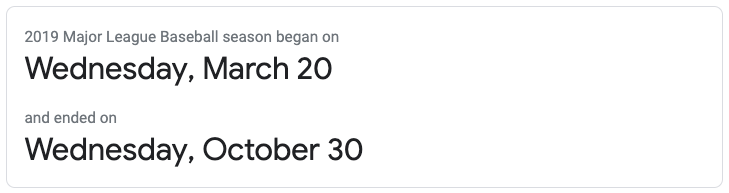

<center> *end dates are slightly different since I am only looking at Regular Season games.

In [14]:
# WARNING: this takes 5 - 10 mins
# only run this once, load df when rerunning notebook


#nineteen = get_date_range_info('2019-03-20', '2019-09-29')
#pd.to_pickle(nineteen, "../pickled_tables/info_strings_2019.pkl")

In [15]:
info_strings_2019 = pd.read_pickle("../pickled_tables/info_strings_2019.pkl")
info_strings_2019

,info_string
https://www.mlb.com/schedule/2019-03-20,"WednesdayMar 20SEASEA@OAKOAKSEA 9, OAK 7Wednes..."
https://www.mlb.com/schedule/2019-03-23,SaturdayMar 23Spring TrainingPITPIT@BOSBOSBOS ...
https://www.mlb.com/schedule/2019-03-26,"TuesdayMar 26Spring TrainingDETDET@TBTBTB 9, D..."
https://www.mlb.com/schedule/2019-03-29,"FridayMar 29DETDET@TORTORTOR 6, DET 0HOUHOU@TB..."
https://www.mlb.com/schedule/2019-04-01,"MondayApr 1STLSTL@PITPITSTL 6, PIT 5CWSCWS@CLE..."
...,...
https://www.mlb.com/schedule/2019-09-16,"MondaySep 16BALBAL@DETDETDET 5, BAL 2CWSCWS@MI..."
https://www.mlb.com/schedule/2019-09-19,"ThursdaySep 19PHIPHI@ATLATLATL 5, PHI 4SEASEA@..."
https://www.mlb.com/schedule/2019-09-22,"SundaySep 22SEASEA@BALBALBAL 2, SEA 1TORTOR@NY..."
https://www.mlb.com/schedule/2019-09-25,"WednesdaySep 25STLSTL@AZAZAZ 9, STL 7MINMIN@DE..."


In [16]:
games_by_day_2019 = annual_games(info_strings_2019)
pd.to_pickle(games_by_day_2019, "../pickled_tables/2019_df.pkl")

games_by_day_2019.tail()

,Day,Month,Date,Away,Home,Win,W Score,Lose,L Score
2428,Sunday,Sep,29,ATL,NYM,NYM,7,ATL,6
2429,Sunday,Sep,29,DET,CWS,CWS,5,DET,3
2430,Sunday,Sep,29,MIL,COL,COL,4,MIL,3
2431,Sunday,Sep,29,CHC,STL,STL,9,CHC,0
2432,Sunday,Sep,29,MIN,KC,KC,5,MIN,4


# Get games for 2021 Regular Season

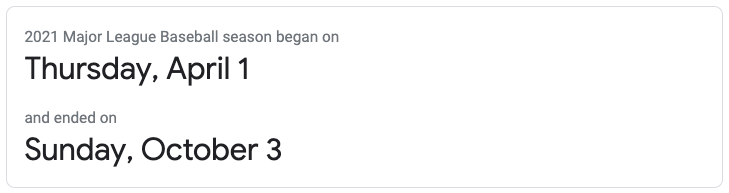

<center> *end dates are slightly different since I am only looking at Regular Season games.

In [17]:
# WARNING: this takes 5 - 10 mins
# only run this once, load df when rerunning notebook


#twentyone = get_date_range_info('2021-04-01', '2021-10-03')
#pd.to_pickle(twentyone, "../pickled_tables/info_strings_2021.pkl")

In [18]:
info_strings_2021 = pd.read_pickle("../pickled_tables/info_strings_2021.pkl")
info_strings_2021

,info_string
https://www.mlb.com/schedule/2021-04-01,"ThursdayApr 1TORTOR@NYYNYYTOR 3, NYY 2CLECLE@D..."
https://www.mlb.com/schedule/2021-04-04,"SundayApr 4ATLATL@PHIPHIPHI 2, ATL 1TORTOR@NYY..."
https://www.mlb.com/schedule/2021-04-07,"WednesdayApr 7ATLATL@WSHWSHATL 7, WSH 6ATLATL@..."
https://www.mlb.com/schedule/2021-04-10,"SaturdayApr 10MIAMIA@NYMNYMMIA 3, NYM 0NYYNYY@..."
https://www.mlb.com/schedule/2021-04-13,"TuesdayApr 13BOSBOS@MINMINBOS 4, MIN 2OAKOAK@A..."
...,...
https://www.mlb.com/schedule/2021-09-19,"SundaySep 19COLCOL@WSHWSHWSH 3, COL 0CLECLE@NY..."
https://www.mlb.com/schedule/2021-09-22,"WednesdaySep 22TORTOR@TBTBTB 7, TOR 1WSHWSH@MI..."
https://www.mlb.com/schedule/2021-09-25,"SaturdaySep 25STLSTL@CHCCHCSTL 8, CHC 5PITPIT@..."
https://www.mlb.com/schedule/2021-09-28,"TuesdaySep 28MIAMIA@NYMNYMNYM 5, MIA 2MIAMIA@N..."


In [19]:
games_by_day_2021 = annual_games(info_strings_2021)
pd.to_pickle(games_by_day_2021, "../pickled_tables/2021_df.pkl")

games_by_day_2021.tail()

,Day,Month,Date,Away,Home,Win,W Score,Lose,L Score
2437,Sunday,Oct,3,DET,CWS,DET,5,CWS,2
2438,Sunday,Oct,3,PHI,MIA,MIA,5,PHI,4
2439,Sunday,Oct,3,MIL,LAD,LAD,10,MIL,3
2440,Sunday,Oct,3,CHC,STL,CHC,3,STL,2
2441,Sunday,Oct,3,NYM,ATL,ATL,5,NYM,0


In [20]:
games_by_day_2021[games_by_day_2021['Win']=="AT"]

,Day,Month,Date,Away,Home,Win,W Score,Lose,L Score


In [21]:
info_strings_2021['info_string']['https://www.mlb.com/schedule/2021-09-16']

'ThursdaySep 16CINCIN@PITPITCIN 1, PIT 0OAKOAK@KCKCOAK 7, KC 2LAALAA@CWSCWSLAA 9, CWS 3SDSD@SFSFSD 7, SF 4NYYNYY@BALBALBAL 3, NYY 2CHCCHC@PHIPHIPHI 17, CHC 8DETDET@TBTBTB 5, DET 2HOUHOU@TEXTEXHOU 12, TEX 1COLCOL@ATLATLCancelledFridaySep 17COLCOL@WSHWSHCOL 9, WSH 8CLECLE@NYYNYYNYY 8, CLE 0MINMIN@TORTORMIN 7, TOR 3BALBAL@BOSBOSBOS 7, BAL 1LADLAD@CINCINCIN 3, LAD 1DETDET@TBTBTB 7, DET 4PHIPHI@NYMNYMPHI 4, NYM 3PITPIT@MIAMIAPIT 2, MIA 1CWSCWS@TEXTEXCWS 8, TEX 0AZAZ@HOUHOUHOU 4, AZ 3SEASEA@KCKCSEA 6, KC 2CHCCHC@MILMILMIL 8, CHC 5SDSD@STLSTLSTL 8, SD 2OAKOAK@LAALAAOAK 5, LAA 4ATLATL@SFSFSF 6, ATL 5SaturdaySep 18CLECLE@NYYNYYCLE 11, NYY 3BALBAL@BOSBOSBOS 9, BAL 3LADLAD@CINCINLAD 5, CIN 1MINMIN@TORTORTOR 6, MIN 2COLCOL@WSHWSHCOL 6, WSH 0DETDET@TBTBDET 4, TB 3PITPIT@MIAMIAPIT 6, MIA 3CWSCWS@TEXTEXTEX 2, CWS 1AZAZ@HOUHOUAZ 6, HOU 4SEASEA@KCKCKC 8, SEA 1SDSD@STLSTLSTL 3, SD 2PHIPHI@NYMNYMPHI 5, NYM 3CHCCHC@MILMILMIL 6, CHC 4ATLATL@SFSFSF 2, ATL 0OAKOAK@LAALAAOAK 3, LAA 1'

# Get games for 2022 Regular Season

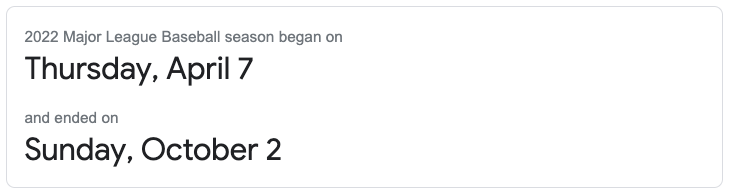

<center> *end dates are slightly different since I am only looking at Regular Season games.

In [22]:
# WARNING: this takes 5 - 10 mins
# only run this once, load df when rerunning notebook


#twentytwo = get_date_range_info('2022-04-07', '2022-10-05')
#pd.to_pickle(twentytwo, "../pickled_tables/info_strings_2022.pkl")

In [23]:
info_strings_2022 = pd.read_pickle("../pickled_tables/info_strings_2022.pkl")
info_strings_2022

,info_string
https://www.mlb.com/schedule/2022-04-07,"ThursdayApr 7MILMIL@CHCCHCCHC 5, MIL 4CLECLE@K..."
https://www.mlb.com/schedule/2022-04-10,"SundayApr 10OAKOAK@PHIPHIOAK 4, PHI 1BALBAL@TB..."
https://www.mlb.com/schedule/2022-04-13,"WednesdayApr 13WSHWSH@ATLATLWSH 3, ATL 1CLECLE..."
https://www.mlb.com/schedule/2022-04-16,"SaturdayApr 16AZAZ@NYMNYMAZ 3, NYM 2TBTB@CWSCW..."
https://www.mlb.com/schedule/2022-04-19,"TuesdayApr 19AZAZ@WSHWSHWSH 6, AZ 1AZAZ@WSHWSH..."
...,...
https://www.mlb.com/schedule/2022-09-22,"ThursdaySep 22LAALAA@TEXTEXTEX 5, LAA 3MINMIN@..."
https://www.mlb.com/schedule/2022-09-25,"SundaySep 25HOUHOU@BALBALHOU 6, BAL 3ATLATL@PH..."
https://www.mlb.com/schedule/2022-09-28,"WednesdaySep 28CINCIN@PITPITPIT 4, CIN 3TBTB@C..."
https://www.mlb.com/schedule/2022-10-01,"SaturdayOct 1PHIPHI@WSHWSHWSH 13, PHI 4PHIPHI@..."


In [24]:
games_by_day_2022 = annual_games(info_strings_2022)
pd.to_pickle(games_by_day_2022, "../pickled_tables/2022_df.pkl")

games_by_day_2022.tail()

,Day,Month,Date,Away,Home,Win,W Score,Lose,L Score
2426,Wednesday,Oct,5,PHI,HOU,HOU,3,PHI,2
2427,Wednesday,Oct,5,MIN,CWS,MIN,10,CWS,1
2428,Wednesday,Oct,5,ATL,MIA,MIA,12,ATL,9
2429,Wednesday,Oct,5,AZ,MIL,AZ,4,MIL,2
2430,Wednesday,Oct,5,COL,LAD,LAD,6,COL,1
